In [32]:
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
import numpy as np
import xarray as xr
import pandas as pd
from scipy.ndimage import label, center_of_mass
from sklearn.metrics import r2_score
import math
import matplotlib.pyplot as plt

from holodecml.data import load_raw_datasets, load_train_patches


In [2]:
path_data = "/glade/p/cisl/aiml/ai4ess_hackathon/holodec/"
num_particles = "medium"
output_cols = ["x", "y", "z", "d", "hid"]
subset = False
scaler_out = MinMaxScaler()
rad = 32


In [3]:
def scale_images(images, scaler_in=None):
    """
    Takes in array of images and scales pixel values between 0 and 1
    
    Args: 
        images: (np array) Input image data
        scaler_in: (dict) Image scaler 'max' and 'min' values
        
    Returns:
        images_scaled: (np array) Input image data scaled between 0 and 1
        scaler_in: (dict) Image scaler 'max' and 'min' values
    """
    
    if scaler_in is None:
        scaler_in = {}
        scaler_in["min"] = images.min()
        scaler_in["max"] = images.max()
    images_scaled = (images.astype(np.float32) - scaler_in["min"])
    images_scaled /= (scaler_in["max"] - scaler_in["min"])

    return images_scaled, scaler_in

In [4]:
def load_pred_patches(path_preds, path_data, num_particles, output_cols,
                       scaler_out=False, subset=False, rad=False, threshold=0.3):
    
    '''Creates hologram patches centered around true (for train) and predicted (for validation) particles.'''
    
    # load raw datasets
    train_inputs,\
    train_outputs = load_raw_datasets(path_data, num_particles, 'train',
                                      output_cols, subset)
    valid_inputs,\
    valid_outputs = load_raw_datasets(path_data, num_particles, 'valid',
                                      output_cols, subset)
    print("finished loading raw datasets")
    
    # scale images
    train_inputs, scaler_in = scale_images(train_inputs)
    valid_inputs, _ = scale_images(valid_inputs, scaler_in)
    
    # use scipy.ndimage.label and scipy.ndimage.center_of_mass to extract predicted particles
    preds = xr.open_dataset(path_preds + "train_outputs_pred.nc").to_array()[0, :, :, :, 0]
    coms = []
    for pred in preds:
        holo_label, label_count = label(np.where(pred >= threshold, 1, 0))
        com = np.array(center_of_mass(pred, holo_label, np.arange(1, label_count+1)))
        coms.append(np.round(com).astype(int))
    print("Finished extracting coms from train preds")

    # calculate bin factor from inputs to the jnet model
    x_factor = train_inputs.shape[1] // preds.x.shape[0]
    y_factor = train_inputs.shape[2] // preds.y.shape[0]
    
    # exise patches from zero-padded holograms for validation set
    train_patches = []
    train_x = []
    train_y = []
    train_hids = []
    for hid in train_outputs["hid"].unique().astype(int):
        input_hid = np.pad(train_inputs[hid-1], rad)
        com = coms[hid-1]
        for c in com:
            idx_x, idx_y = int(c[0]*x_factor)+rad, int(c[1]*y_factor)+rad            
            patch = input_hid[idx_x-rad:idx_x+rad+1, idx_y-rad:idx_y+rad+1]
            train_patches.append(patch)
            train_x.append(idx_x-rad)
            train_y.append(idx_y-rad)
            train_hids.append(hid)
    train_patches = np.stack(train_patches)
    train_x = np.array(train_x).reshape(-1,1)
    train_y = np.array(train_y).reshape(-1,1)
    train_hids = np.array(train_hids).reshape(-1,1)
    train_hids = np.hstack((train_hids, train_x, train_y))
    print("Finished extracting train patches")

    # use scipy.ndimage.label and scipy.ndimage.center_of_mass to extract predicted particles
    preds = xr.open_dataset(path_preds + "valid_outputs_pred.nc").to_array()[0, :, :, :, 0]
    coms = []
    for pred in preds:
        holo_label, label_count = label(np.where(pred >= threshold, 1, 0))
        com = np.array(center_of_mass(pred, holo_label, np.arange(1, label_count+1)))
        coms.append(np.round(com).astype(int))
    print("Finished extracting coms from valid preds")

    # calculate bin factor from inputs to the jnet model
    x_factor = valid_inputs.shape[1] // preds.x.shape[0]
    y_factor = valid_inputs.shape[2] // preds.y.shape[0]
    
    # exise patches from zero-padded holograms for validation set
    valid_patches = []
    valid_x = []
    valid_y = []
    valid_hids = []
    for hid in valid_outputs["hid"].unique().astype(int):
        input_hid = np.pad(valid_inputs[hid-1], rad)
        com = coms[hid-1]
        for c in com:
            idx_x, idx_y = int(c[0]*x_factor)+rad, int(c[1]*y_factor)+rad
            patch = input_hid[idx_x-rad:idx_x+rad+1, idx_y-rad:idx_y+rad+1]
            valid_patches.append(patch)
            valid_x.append(idx_x-rad)
            valid_y.append(idx_y-rad)
            valid_hids.append(hid)
    valid_patches = np.stack(valid_patches)
    valid_x = np.array(valid_x).reshape(-1,1)
    valid_y = np.array(valid_y).reshape(-1,1)
    valid_hids = np.array(valid_hids).reshape(-1,1)
    valid_hids = np.hstack((valid_hids, valid_x, valid_y))
    print("Finished extracting valid patches")
    
    train_outputs = train_outputs.drop(['hid'], axis=1)
    train_outputs = scaler_out.fit_transform(train_outputs)
    
    valid_outputs = valid_outputs.drop(['hid'], axis=1)
    valid_outputs = scaler_out.transform(valid_outputs)
    
    return train_patches, train_hids, train_outputs, valid_patches, valid_hids, valid_outputs


In [5]:
path_preds = "/glade/p/cisl/aiml/ggantos/holodec/unet/j_10_fulldata/"

train_patches,\
train_patch_hids,\
train_patch_outputs,\
valid_patches,\
valid_patch_hids,\
valid_patch_outputs = load_pred_patches(path_preds,
                                        path_data,
                                        num_particles,
                                        output_cols,
                                        scaler_out,
                                        subset,
                                        rad)


finished loading raw datasets
Finished extracting coms from train preds
Finished extracting train patches
Finished extracting coms from valid preds
Finished extracting valid patches


In [6]:
path_model = "/glade/p/cisl/aiml/ggantos/holodec/jnet/zd_fft/base/"
new_model = tf.keras.models.load_model(path_model + "cnn.h5")
new_model.summary()


Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 65, 65, 1)]       0         
_________________________________________________________________
conv2D_00 (Conv2D)           (None, 65, 65, 8)         208       
_________________________________________________________________
maxpool2D_00 (MaxPooling2D)  (None, 16, 16, 8)         0         
_________________________________________________________________
conv2D_01 (Conv2D)           (None, 16, 16, 16)        3216      
_________________________________________________________________
maxpool2D_01 (MaxPooling2D)  (None, 4, 4, 16)          0         
_________________________________________________________________
conv2D_02 (Conv2D)           (None, 4, 4, 32)          12832     
_________________________________________________________________
maxpool2D_02 (MaxPooling2D)  (None, 1, 1, 32)         

In [9]:
valid_patch_outputs_pred = new_model.predict(valid_patches)
valid_patch_outputs_pred


array([[0.48244318, 0.5175568 ],
       [0.48286605, 0.5171339 ],
       [0.484155  , 0.51584506],
       ...,
       [0.48267326, 0.5173267 ],
       [0.4822095 , 0.5177905 ],
       [0.4857398 , 0.51426023]], dtype=float32)

In [24]:
df_pred = np.hstack((valid_patch_hids, valid_patch_outputs_pred))
df_pred = pd.DataFrame(data=df_pred, columns=["hid", "x", "y", "z", "d"])
df_pred.head()

,hid,x,y,z,d
0,1.0,30.0,330.0,0.482443,0.517557
1,1.0,80.0,110.0,0.482866,0.517134
2,1.0,110.0,130.0,0.484155,0.515845
3,1.0,130.0,150.0,0.484011,0.515989
4,1.0,150.0,170.0,0.483846,0.516154


In [18]:
train_inputs,\
train_hids,\
train_outputs,\
valid_inputs,\
valid_hids,\
valid_outputs = load_train_patches(path_data,
                                   num_particles,
                                   output_cols,
                                   scaler_out,
                                   subset,
                                   rad)


KeyboardInterrupt: 

In [15]:
valid_hids.shape

(184976, 3)

In [19]:
valid_outputs.shape

(184976, 2)

In [22]:
df_true = np.hstack((valid_hids, valid_outputs))
df_true = pd.DataFrame(data=df_true, columns=["hid", "x", "y", "z", "d"])
df_true


,hid,x,y,z,d
0,1.0,434.0,18.0,0.545434,0.240543
1,1.0,446.0,371.0,0.225631,0.230870
2,1.0,553.0,186.0,0.639477,0.169273
3,1.0,412.0,216.0,0.400571,0.153148
4,1.0,127.0,144.0,0.039595,0.130865
...,...,...,...,...,...
184971,10000.0,261.0,86.0,0.855438,0.185889
184972,10000.0,396.0,42.0,0.046036,0.307331
184973,10000.0,257.0,194.0,0.097955,0.121866
184974,10000.0,33.0,51.0,0.814958,0.079432


In [25]:
loss_counts = []
loss_maxima = []
loss_zs = []
loss_ds = []
true_z = []
true_d = []

for hid in df_pred["hid"].unique().astype(int):
    df_true_hid = df_true.loc[df_true['hid'] == hid]
    df_pred_hid = df_pred.loc[df_pred['hid'] == hid]
    dist_x = (df_true_hid['x'].to_numpy() - df_pred_hid['x'].to_numpy()[:, np.newaxis]) ** 2
    dist_y = (df_true_hid['y'].to_numpy() - df_pred_hid['y'].to_numpy()[:, np.newaxis]) ** 2
    dist_z = (df_true_hid['z'].to_numpy() - df_pred_hid['z'].to_numpy()[:, np.newaxis]) ** 2
    dist_d = (df_true_hid['d'].to_numpy() - df_pred_hid['d'].to_numpy()[:, np.newaxis]) ** 2
    dist_xy = dist_x + dist_y
    matches = np.argmin(dist_xy, axis=1)
    loss_counts.append((df_true_hid.shape[0] - df_pred_hid.shape[0]) ** 2)
    loss_maxima.append(df_true_hid.shape[0] - df_pred_hid.shape[0])
    loss_zs.append(np.sum(dist_z[(np.arange(dist_z.shape[0]), matches)]))
    loss_ds.append(np.sum(dist_d[(np.arange(dist_d.shape[0]), matches)]))
    true_z.append(df_true_hid["z"].to_numpy()[matches])
    true_d.append(df_true_hid["d"].to_numpy()[matches])
loss_count = math.sqrt(sum(loss_counts))
loss_max = max(loss_maxima)
loss_z = math.sqrt(sum(loss_zs))
loss_d = math.sqrt(sum(loss_ds))
true_z = np.hstack(true_z)
true_d = np.hstack(true_d)

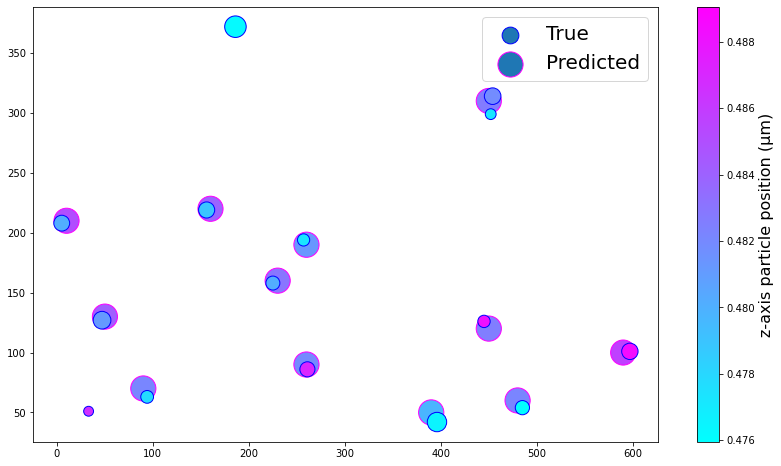

In [30]:
h = 10000
plt.figure(figsize=(14, 8))
plt.scatter(df_true.loc[df_true['hid'] == h, "x"],
            df_true.loc[df_true['hid'] == h, "y"],
            df_true.loc[df_true['hid'] == h, "d"]*35 ** 2,
            df_true.loc[df_true['hid'] == h, "z"],
            edgecolors="blue",
            vmin=df_true["z"].min(),
            vmax=df_true["z"].max(),
            cmap="cool",
            label="True",
            zorder=2)
plt.scatter(df_pred.loc[df_pred['hid'] == h, "x"],
            df_pred.loc[df_pred['hid'] == h, "y"],
            df_pred.loc[df_pred['hid'] == h, "d"]*35 ** 2,
            df_pred.loc[df_pred['hid'] == h, "z"],
            edgecolors="magenta",
            vmin=df_pred["z"].min(),
            vmax=df_pred["z"].max(),
            cmap="cool",
            label="Predicted",
            zorder=1)
plt.colorbar().set_label(label="z-axis particle position (µm)", size=16)
plt.legend(fontsize=20)
plt.show()

r-squared = -16.688


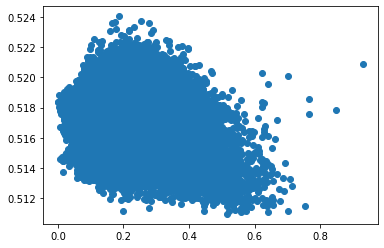

In [39]:
plt.scatter(true_d, df_pred["d"])
print("r-squared = {:.3f}".format(r2_score(true_d, df_pred["d"])))
plt.show()


r-squared = 0.002


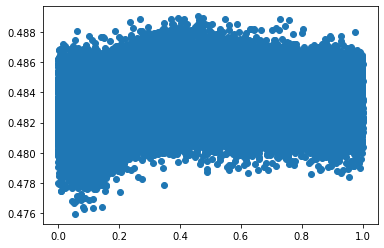

In [40]:
plt.scatter(true_z, df_pred["z"])
print("r-squared = {:.3f}".format(r2_score(true_z, df_pred["z"])))
plt.show()


In [29]:
print(loss_count)
print(loss_max)
print(loss_z)
print(loss_d)


652.5557447452286
20
102.86851690055377
122.59678894667918
